In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

First we contstruct the MDP

In [2]:
class MDP():

    def __init__(self, r_list, Lambda, max_queue_lenght):
        self.LAMBDA = Lambda
        self.R = r_list
        self.N = len(r_list)
        self.state = [0]*self.N
        self.max = max_queue_lenght
    
    def reset(self):
        self.state = [0]*self.N
        return self.state

    def action(self, action):
        cost = 0

        #The new job is routed according to the probabilities of the action
        routed_q = random.choices([i for i in range(self.N)], weights = action)[0]
        self.state[routed_q] += 1

        for i in range(self.N):
            size = self.state[i]
            
            #the size of the queue is added to the cost
            cost += - size

            #The queues sizes are updated
            if size != 0:
                served_jobs = random.choices([k for k in range(size + 1)], weights=[self.__q(i,j) for j in range(size + 1)])[0]
                self.state[i] -= served_jobs

        #make state for return considering maximum queue size      
        state = [0 for _ in range(self.N)]
        for queue in range(self.N):
            state[queue] = self.state[queue]
            if self.state[queue] > self.max:
                state[queue] = self.max

        return (state, cost)

    def state(self):
        return self.state

    def __q(self, i, j): #the probability that j jobs are served at Queue i
        if j == self.state[i]:
            return((self.R[i] / (self.R[i] + self.LAMBDA))**j)
        else:
           return(self.LAMBDA * (self.R[i]**j) / (self.R[i] + self.LAMBDA)**j)

Action space

In [3]:
#recursive function for the generation of the action space
def rec(action, d, N, sum, len):
    if len > N:
        return []
    elif len == N:
        if sum == d:
            return [action]
        return []
    elif sum == d:
        return rec(action + [0], d, N, sum, len+1)
    ans = []
    i = 0
    while sum+i <= d:
        ans += rec(action+[i/d], d, N, sum+i, len+1)
        i += 1
    return ans

def action_space(d, N):
    return rec([], d, N, 0, 0)


State space

In [4]:
def rec_s(state, N, len, max_queue_length):
    if len > N:
        return []
    elif len == N:
        return [state]
    ans = []
    i = 0
    while i <= max_queue_length:
        ans += rec_s(state+[i], N, len+1, max_queue_length)
        i += 1
    return ans

def state_space(N, max):
    return rec_s([], N, 0, max)

The Q-learning algorithm:

In [61]:
# ns = 30000 #number of steps per episode
# ne = 3000 #number of episodes
# e = 10 #probability taking a random action
# delta = 0.5 #discount factor
# l_rate = 0.6 #learning rate

# r_list = [0.5, 0.5] #list of the server rates
# l = 0.5 #lambda

# d = 10
# max_queue_length = 50

def qber(ns, ne, e, delta, l_rate, r_list, l, d, max_queue_length):

    #########
    title = 'ns: '+ str(ns)+ ' ne: '+ str(ne)+ ' ε: '+ str(e)+ ' δ: '+ str(delta)+ ' l rate:', l_rate, ' r list: '+ str(r_list)+ ' λ: '+ str(l)+ ' d:'+ str(d)+ ' max: '+ str(max_queue_length)
    plt.title(title)
    #########

    N = len(r_list)
    #generation of the action space
    action_s = action_space(d, N)
    action_s_size = len(action_s)

    #generation of the states
    state_s = state_space(N, max_queue_length)
    state_s_size = len(state_s)

    ###
    qplot = [[] for _ in range(action_s_size)]
    ###

    #generation of the q-table
    act_len = len(action_s)
    q = np.zeros((len(state_s), act_len))

    mdp = MDP(r_list, l, max_queue_length)

    class QueueError(Exception):
        pass

    #########
    points = [[] for action in action_s]
    #########

    for episode in range(ne ):
        #print((episode+1)/ne, 'eps.:', e, action_s[np.argmax(q[0])])
        print(round((episode+1)/ne, 5), end='\r')

        #########
        if e > 1:
            cambio1 = episode
        if e > 0:
            cambio0 = episode
        
        new_points = [0 for _ in range(action_s_size)]
        for _s in range(state_s_size):
            winner = np.argmax(q[_s,:])
            if q[_s, winner] != 0:
                new_points[winner] += 1
        for _a in range(action_s_size):
            points[_a].append(new_points[_a])
        #########
        
        #get initial state
        state = mdp.reset()
        #check for queue length
        if state in state_s:
            state_number = state_s.index(state)
        else:
            raise QueueError

        for step in range(1, ns+1): #starts on 1 to avoid /0 in learning rate

            ###
            if step%1000 == 999:
                for _a in range(action_s_size):
                    qplot[_a].append(q[1, _a])
            ###
            
            #take minimun quality action
            if random.uniform(0,1) > e:
                action_number = np.argmax(q[state_s.index(state)])
                action = action_s[action_number]
            #take random action
            else:
                action = random.choices(action_s)[0]
                action_number = action_s.index(action)

            #take action, get new_state and reward
            (new_state, cost) = mdp.action(action)
            new_state_number = state_s.index(new_state)
            
            #update q-table
            q[state_number, action_number] = q[state_number, action_number] + (1/(step**l_rate))*(cost + delta*np.max(q[new_state_number, :]) - q[state_number, action_number])

            state = new_state
            state_number = new_state_number
            e -= 0.0001

    #########
    for act in action_s:
        act_number = action_s.index(act)
        plt.plot(points[act_number], label = act)
    plt.axvline(x=cambio0, c='grey')
    plt.axvline(x=cambio1, c='grey')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    #########

    ###
    return qplot
    ###

1 / 5 = 0.2
 1.0                                  

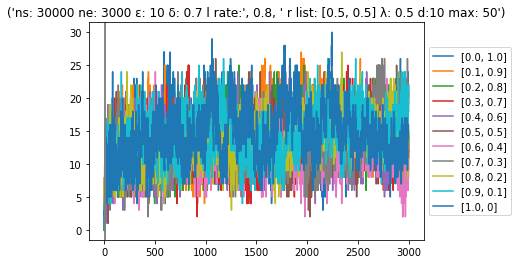

2 / 5 = 0.4
 1.0                                  

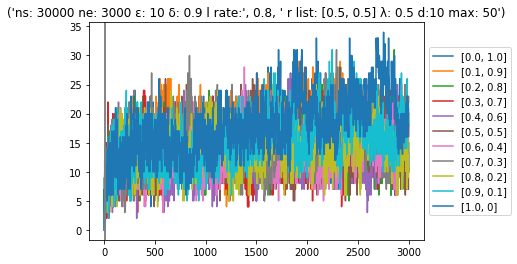

3 / 5 = 0.6
 1.0                                  

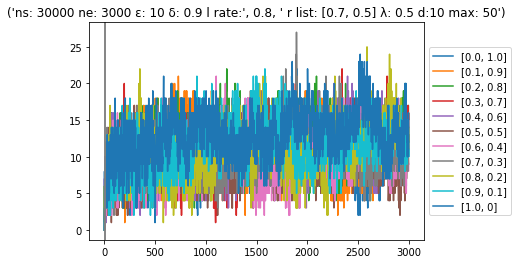

4 / 5 = 0.8
 1.0                                  

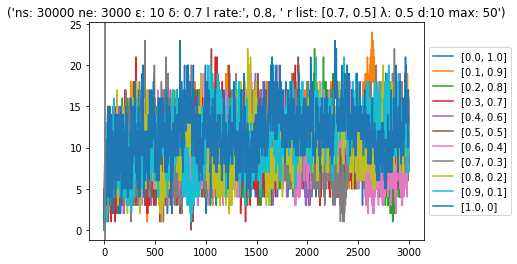

5 / 5 = 1.0
 1.0                                  

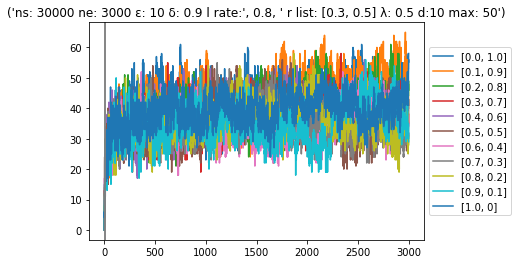

In [6]:
tests = [
    # # (
    # #     30000, #number of steps per episode
    # #     3000, #number of episodes
    # #     10, #probability taking a random action
    # #     0.9, #discount factor
    # #     0.8, #learning rate
    # #     [0.7, 0.5, 0.3, 0.2], #list of the server rates
    # #     0.2, #lambda
    # #     10, #d
    # #     50 #max_queue_length
    # # ),
    # (
    #     30, #number of steps per episode
    #     3000, #number of episodes
    #     10, #probability taking a random action
    #     0.5, #discount factor
    #     0.8, #learning rate
    #     [0.5, 0.5], #list of the server rates
    #     15, #lambda
    #     10, #d
    #     50 #max_queue_length
    # ),
    # (
    #     300, #number of steps per episode
    #     3000, #number of episodes
    #     10, #probability taking a random action
    #     0.5, #discount factor
    #     0.8, #learning rate
    #     [0.5, 0.5], #list of the server rates
    #     0.5, #lambda
    #     10, #d
    #     50 #max_queue_length
    # ),
    # (
    #     3000, #number of steps per episode
    #     3000, #number of episodes
    #     10, #probability taking a random action
    #     0.5, #discount factor
    #     0.8, #learning rate
    #     [0.5, 0.5], #list of the server rates
    #     0.5, #lambda
    #     10, #d
    #     50 #max_queue_length
    # ),
    # (
    #     30000, #number of steps per episode
    #     3000, #number of episodes
    #     10, #probability taking a random action
    #     0.5, #discount factor
    #     0.8, #learning rate
    #     [0.5, 0.5], #list of the server rates
    #     0.5, #lambda
    #     10, #d
    #     50 #max_queue_length
    # ),
    # (
    #     30000, #number of steps per episode
    #     3000, #number of episodes
    #     10, #probability taking a random action
    #     0.2, #discount factor
    #     0.8, #learning rate
    #     [0.5, 0.5], #list of the server rates
    #     0.5, #lambda
    #     10, #d
    #     50 #max_queue_length
    # ),
    # (
    #     30000, #number of steps per episode
    #     3000, #number of episodes
    #     10, #probability taking a random action
    #     0.1, #discount factor
    #     0.8, #learning rate
    #     [0.5, 0.5], #list of the server rates
    #     0.5, #lambda
    #     10, #d
    #     50 #max_queue_length
    # ),
    (
        30000, #number of steps per episode
        3000, #number of episodes
        10, #probability taking a random action
        0.7, #discount factor
        0.8, #learning rate
        [0.5, 0.5], #list of the server rates
        0.5, #lambda
        10, #d
        50 #max_queue_length
    ),
    (
        30000, #number of steps per episode
        3000, #number of episodes
        10, #probability taking a random action
        0.9, #discount factor
        0.8, #learning rate
        [0.5, 0.5], #list of the server rates
        0.5, #lambda
        10, #d
        50 #max_queue_length
    ),
    (
        30000, #number of steps per episode
        3000, #number of episodes
        10, #probability taking a random action
        0.9, #discount factor
        0.8, #learning rate
        [0.7, 0.5], #list of the server rates
        0.5, #lambda
        10, #d
        50 #max_queue_length
    ),
    (
        30000, #number of steps per episode
        3000, #number of episodes
        10, #probability taking a random action
        0.7, #discount factor
        0.8, #learning rate
        [0.7, 0.5], #list of the server rates
        0.5, #lambda
        10, #d
        50 #max_queue_length
    ),
    (
        30000, #number of steps per episode
        3000, #number of episodes
        10, #probability taking a random action
        0.9, #discount factor
        0.8, #learning rate
        [0.3, 0.5], #list of the server rates
        0.5, #lambda
        10, #d
        50 #max_queue_length
    )
]

count = 1
T = len(tests)
for ns, ne, e, delta, l_rate, r_list, l, d, max_queue_length in tests:
    print(count, '/', T, '=', count/T)
    qber(ns, ne, e, delta, l_rate, r_list, l, d, max_queue_length)
    count += 1

1 / 1 = 1.0


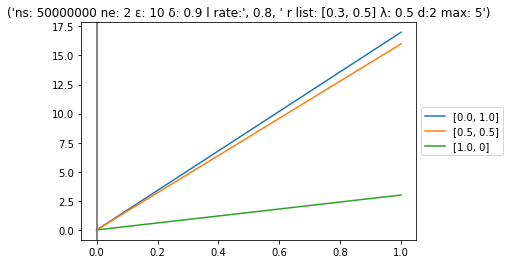

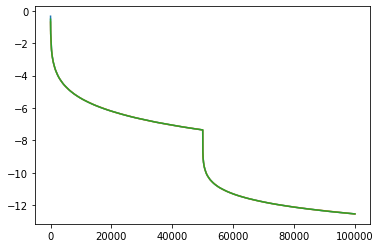

In [62]:
tests = [
    (
        50000000, #number of steps per episode
        2, #number of episodes
        10, #probability taking a random action
        0.9, #discount factor
        0.8, #learning rate
        [0.3, 0.5], #list of the server rates
        0.5, #lambda
        2, #d
        5 #max_queue_length
    )
]

count = 1
T = len(tests)
for ns, ne, e, delta, l_rate, r_list, l, d, max_queue_length in tests:
    print(count, '/', T, '=', count/T)
    qplot = qber(ns, ne, e, delta, l_rate, r_list, l, d, max_queue_length)
    count += 1
    for _q in qplot:
        plt.plot(_q)

1 / 1 = 1.0


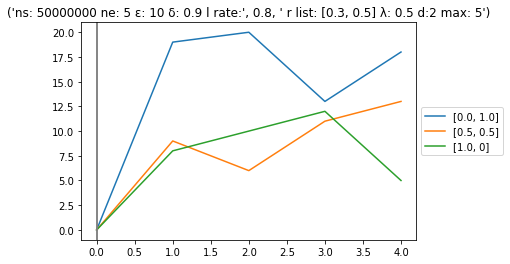

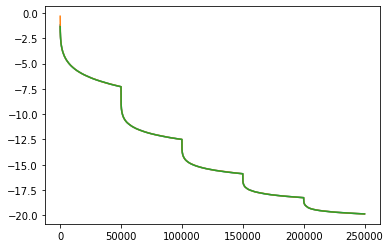

In [63]:
tests = [
    (
        50000000, #number of steps per episode
        5, #number of episodes
        10, #probability taking a random action
        0.9, #discount factor
        0.8, #learning rate
        [0.3, 0.5], #list of the server rates
        0.5, #lambda
        2, #d
        5 #max_queue_length
    )
]

count = 1
T = len(tests)
for ns, ne, e, delta, l_rate, r_list, l, d, max_queue_length in tests:
    print(count, '/', T, '=', count/T)
    qplot = qber(ns, ne, e, delta, l_rate, r_list, l, d, max_queue_length)
    count += 1
    for _q in qplot:
        plt.plot(_q)

In [66]:
state_space(2,5)[1]

[0, 1]